Source: Getting started with NLP for absolute beginners   
https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners/notebook

Fast AI Course Lesson 4: https://www.youtube.com/watch?v=toUgBQv1BT8

Classification models can be usedto categorize documents, for example, do sentiment analysis, identify authors, legal discovery. 
Classification models can also be used to solve other kinds of problems. This is the US Patent Phrase to Phrase Matching competition. 

> In this, we are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in. With a score of 1 it is considered that the two inputs have identical meaning, and 0 means they have totally different meaning. For instance, abatement and eliminating process have a score of 0.5, meaning they're somewhat similar, but not identical.
> It turns out that this can be represented as a classification problem. How? By representing the question like this:
>  >  For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".
> In this notebook we'll see how to solve the Patent Phrase Matching problem by treating it as a classification task, by representing it in a very similar way to that shown above.
>

In [10]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Unfortunately Kaggle is not privacy friendly, and requires submitting a phone number for verification before being able to download the dataset. Its privacy policy does not have much information about how the phone number actually verifies the account and what they do with the phone number afterwards. Very reluctantly proceeding (and disappointed): 

In [11]:
import os 
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
path = Path('us-patent-phrase-to-phrase-matching')


if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)



In [12]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

Since it's CSV files, best to use the Pandas library

In [13]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [14]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [15]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

Next step is tokenization. Text can't be passed directly into a model, it needs to be tokenized first. For that reason we need to tokenize it (split text into tokens) and numericalize it (convert each token into numbers). How it happens differs by model, so the model chosen here is microsoft/deberta-v3-small. 


In [16]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [17]:
model_nm = 'microsoft/deberta-v3-small'

In [18]:
# Not sure why, but this doesn't work locally without adding this environment variable. 

%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


In [19]:

from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/mendhak/miniconda3/envs/fastai/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
tokz.tokenize("The quick brown fox jumps over the lazy little dogs. I'm on my way to the store where the fox lives, indubitably.")

['▁The',
 '▁quick',
 '▁brown',
 '▁fox',
 '▁jumps',
 '▁over',
 '▁the',
 '▁lazy',
 '▁little',
 '▁dogs',
 '.',
 '▁I',
 "'",
 'm',
 '▁on',
 '▁my',
 '▁way',
 '▁to',
 '▁the',
 '▁store',
 '▁where',
 '▁the',
 '▁fox',
 '▁lives',
 ',',
 '▁in',
 'du',
 'bit',
 'ably',
 '.']

In [24]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [25]:
# Define a function to tokenize the input column of a dataset.
def tok_func(x): return tokz(x["input"])

In [28]:
# Use the .map() function to tokenize the dataset in parallel. 
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [29]:
tok_ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'score': 0.5,
 'input': 'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 'input_ids': [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [33]:
# In the tokenizer there's a built in vocab list which corresponds to the IDs above. 
tokz.vocab['▁hello']

12018

In [34]:
#Transformers is expecting the 'score' column to be called 'labels'. It needs to be renamed. 

tok_ds = tok_ds.rename_columns({'score':'labels'})
tok_ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'labels': 0.5,
 'input': 'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 'input_ids': [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Create validation and test sets. 

In [38]:
# Inspect the test csv which is the test dataset. 
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [39]:
# Create the test set. 
test_df['input'] = 'TEXT1: ' + test_df.context + '; TEXT2: ' + test_df.target + '; ANC1: ' + test_df.anchor
test_ds = Dataset.from_pandas(test_df).map(tok_func, batched=True)


Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [40]:
# Create a validation dataset.  
validation_ds = tok_ds.train_test_split(0.25, seed=1234)
validation_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

A validation set is used as part of training, and it is used to report metrics about the training. 
A test set is held back from training, and is only used to see how the model performs afterwards. Most important difference is that test sets are held back from training. 

## The metrics: Pearson correlation coefficient
In this case, the metric that's being evaluated for the final is the pearson correlation coefficient between the actual and predicted scores. 

A bit more about it 

In [41]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [43]:
# To see the correlation coefficients, use np's corrcoef. 

import numpy as np, matplotlib.pyplot as plt

np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing.MedInc, housing.MedHouseVal)
# This shows the correlation between Median Income and Median House value. 

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [44]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)



0.6760250732906005

In [45]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

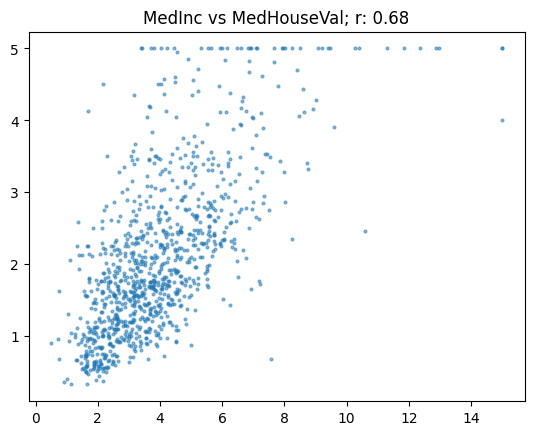

In [46]:
show_corr(housing, 'MedInc', 'MedHouseVal')


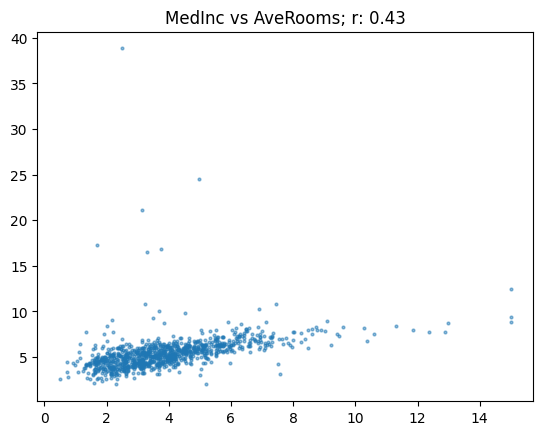

In [47]:
show_corr(housing, 'MedInc', 'AveRooms')

r is very sensitive to outliers. If there's outliers in your data, then the relationship between them will dominate the metric. In this case, the houses with a very high number of rooms don't tend to be that valuable, so it's decreasing r from where it would otherwise be.

Now try again by removing outliers. 



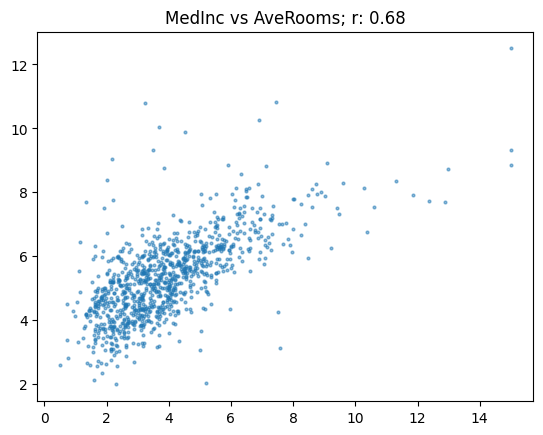

In [48]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')


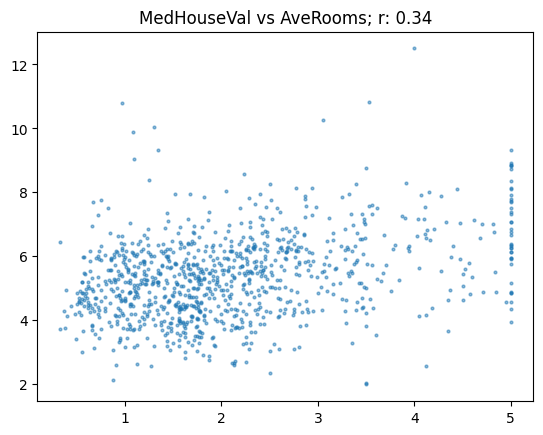

In [49]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

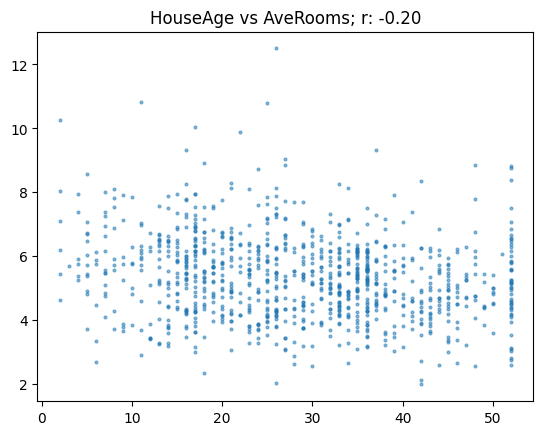

In [50]:
show_corr(subset, 'HouseAge', 'AveRooms')

So we can see the coefficient shows the strength of the relationship between the two metrics. Higher the value the stronger the correlation. 

## continuing... 

In [51]:
# Function needed for transformers later
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [66]:
from transformers import TrainingArguments, Trainer

In [54]:
batch_size = 128
epochs = 4

In [55]:
learning_rate = 8e-5

In [64]:
arguments = TrainingArguments('outputs', learning_rate=learning_rate, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True, 
                              evaluation_strategy="epoch", per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size*2, num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [67]:


model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, arguments, train_dataset=validation_ds['train'], eval_dataset=validation_ds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)



Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [68]:
trainer.train()

/home/mendhak/miniconda3/envs/fastai/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.02587033063173294, 'eval_pearson': 0.8013500227847442, 'eval_runtime': 1.4563, 'eval_samples_per_second': 6261.705, 'eval_steps_per_second': 24.72, 'epoch': 1.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.02246789261698723, 'eval_pearson': 0.8236019041461338, 'eval_runtime': 1.4713, 'eval_samples_per_second': 6198.088, 'eval_steps_per_second': 24.469, 'epoch': 2.0}
{'loss': 0.0356, 'learning_rate': 3.544034360437838e-05, 'epoch': 2.34}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.02320932224392891, 'eval_pearson': 0.8327813601417974, 'eval_runtime': 1.4766, 'eval_samples_per_second': 6175.56, 'eval_steps_per_second': 24.38, 'epoch': 3.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 0.022707274183630943, 'eval_pearson': 0.8346160400082611, 'eval_runtime': 1.5083, 'eval_samples_per_second': 6045.964, 'eval_steps_per_second': 23.868, 'epoch': 4.0}
{'train_runtime': 110.7416, 'train_samples_per_second': 988.029, 'train_steps_per_second': 7.73, 'train_loss': 0.026534933910191617, 'epoch': 4.0}


TrainOutput(global_step=856, training_loss=0.026534933910191617, metrics={'train_runtime': 110.7416, 'train_samples_per_second': 988.029, 'train_steps_per_second': 7.73, 'train_loss': 0.026534933910191617, 'epoch': 4.0})

In [70]:
# get predictions on the test set. 

preds = trainer.predict(test_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)
preds

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0.65],
       [0.79],
       [0.56],
       [0.32],
       [0.  ],
       [0.48],
       [0.43],
       [0.  ],
       [0.39],
       [1.  ],
       [0.27],
       [0.22],
       [0.8 ],
       [0.75],
       [0.75],
       [0.4 ],
       [0.23],
       [0.  ],
       [0.6 ],
       [0.35],
       [0.43],
       [0.21],
       [0.07],
       [0.19],
       [0.56],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.42],
       [0.2 ],
       [0.  ],
       [0.66],
       [0.56],
       [0.43],
       [0.21]])

In [71]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

851